In [25]:
import requests
from tqdm import tqdm
from os.path import join as oj
import numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
import pickle as pkl
from skimage.util import img_as_float
import h5py
from copy import deepcopy
from skimage.filters import gabor_kernel
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# plt.style.use('dark_background')
from run import *
out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'
# dec1_2 didn't normalize sigmas, dec1_3 did, dec1_4 adds all test accs
# dec1_6 sets variance to 0.1
# dec1_6 sets variance to 1 (best)
# dec2_small_1 runs using smaller data (720 points instead of 7200)
save_dir = oj(out_dir, 'dec14_baselines_ard') 
reg_params = np.logspace(3, 6, 20).round().astype(int)

# load fits
rois = ['v1lh', 'v1rh', 'v2lh', 'v2rh', 'v4lh', 'v4rh']
fnames = sorted([fname for fname in os.listdir(save_dir)])
# print('fnames', fnames)
results_list = [pd.Series(pkl.load(open(oj(save_dir, fname), "rb"))) for fname in tqdm(fnames)]
results = pd.concat(results_list, axis=1).T.infer_objects()
# print('results', results.keys())
results['region'] = results['roi'].str.slice(0, 2)
r = results.drop('model', axis=1) # drop model to speed things up
r = results
r.keys()
cb = '#1f77b4'
# print('are largest/smallest lambdas being selected?', np.unique(r['lambda_best'], return_counts=True))

# add some extra keys
lambdas = np.logspace(3, 6, 20).round().astype(int) # reg values to try (must match preprocess_fmri)
lambda_map = {
    lambdas[i]: i for i in range(lambdas.size)
}
r['lambda_best_idx'] = r['lambda_best'].map(lambda_map)
r['mse_norm'] = [r['mse_norms'].iloc[i][r['lambda_best_idx'].iloc[i]] for i in range(r.shape[0])]
r['eigensum'] = [r['eigensums'].iloc[i][r['lambda_best_idx'].iloc[i]] for i in range(r.shape[0])]
r['theta_norm'] = [r['theta_norms'].iloc[i][r['lambda_best_idx'].iloc[i]] for i in range(r.shape[0])]

100%|██████████| 93/93 [00:00<00:00, 351.88it/s]


In [20]:
r.keys()

Index(['roi', 'model', 'snr', 'lambda_best', 'n_train', 'n_test', 'd',
       'y_norm', 'idx', 'lambda_opt', 'theta_opt', 'mdl_comp_opt',
       'mse_test_mdl', 'cv_values', 'mse_train', 'r2_train', 'mse_test',
       'r2_test', 'corr_test', 'mse_norms', 'theta_norms', 'eigensums',
       'mdl_comps', 'mse_tests', 'ard_mse_train', 'ard_r2_train', 'ard_mse',
       'ard_r2', 'ard_corr', 'region'],
      dtype='object')

**main fig**

In [ ]:
R, C = 1, 3
plt.figure(figsize=(10, 3.5))

plt.subplot(R, C, 1)
plt.plot(r['ard_mse'], r['mse_test_mdl'],  '.')
plt.plot([0.95, 1.7], [0.95, 1.7], color='gray', linestyle='--')
plt.xlim([0.95, 1.7])
plt.ylim([0.95, 1.7])
plt.ylabel('Test MSE (Prac-MDL-COMP)')
plt.xlabel('Test MSE (Ridge-ARD)')
plt.grid()
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.plot(r['mse_test'], r['mse_test_mdl'], '.')
plt.plot([0.95, 1.2], [0.95, 1.2], color='gray', linestyle='--')
plt.xlim([0.95, 1.2])
plt.ylabel('Test MSE (Prac-MDL-COMP)')
plt.xlabel('Test MSE (Ridge-CV)')
plt.grid()
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
for i in range(8): #min(5, r.shape[0])): #r.shape[0]):
    row = r.iloc[i]
    plt.plot(row['mdl_comps'], row['mse_tests'], '-', ms=1, label=str(i), color='gray')
    plt.xlabel('Prac-MDL-COMP Objective')
    plt.ylabel('Test MSE')
x = np.vstack(r['mdl_comps'].values).mean(axis=0)
y = np.vstack(r['mse_tests'].values).mean(axis=0)
plt.plot(x, y, color=cb, lw=4)
plt.text(x[0] + 0.005, y[0], s='Mean', fontsize=14, color=cb)
plt.title('C', loc='left', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/fig_fmri_results.pdf')
plt.show()

# check performance

In [ ]:
R, C = 1, 2
plt.subplot(R, C, 1)
plt.xlabel('Test corr')
plt.ylabel('Count')
plt.hist(r['corr_test']) #, bins=100)

plt.subplot(R, C, 2)
lambdas, counts = np.unique(r.lambda_best, return_counts=True)
# plt.bar(np.arange(counts.size), counts) #, 'o-')
plt.plot(lambdas, counts, 'o-', label='CV')
# plt.xticks(np.arange(counts.size), labels=lambdas)
# ax.ticklabel_format(axis='both', style='sci')

plt.ylabel('Count')
plt.xlabel('Lambda_best_CV')
plt.xscale('log')

# plt.subplot(R, C, 3)
lambdas, counts = np.unique(r.lambda_opt, return_counts=True)
plt.plot(lambdas, counts, 'o-', label='MDL-COMP')
plt.ylabel('Count')
plt.xlabel('Lambda_best_MDL')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# evaluate complexity

**scatter plots**

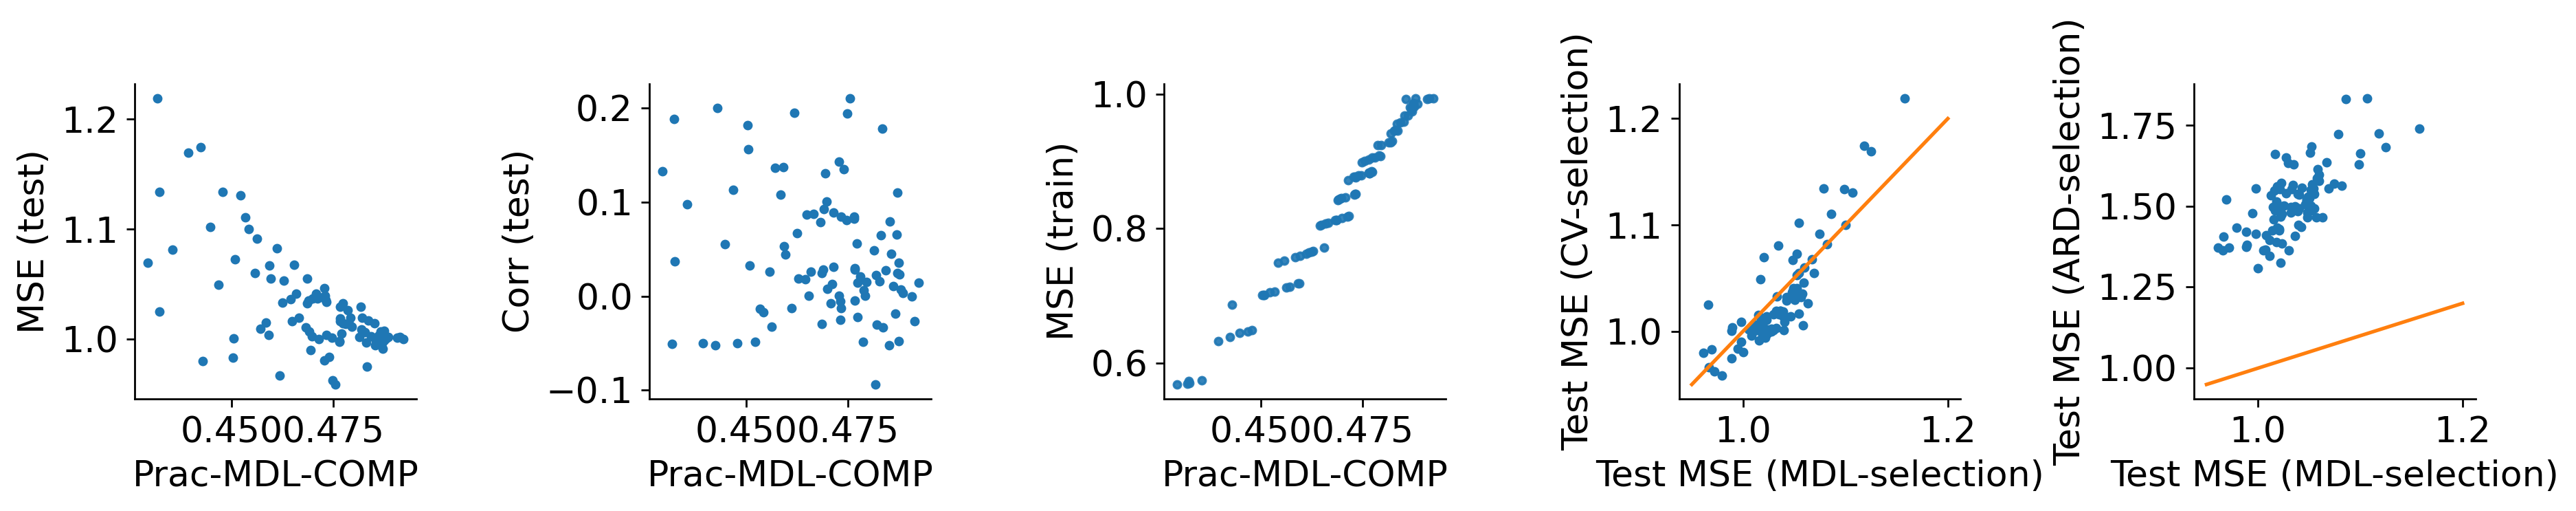

In [28]:
N = 5
f, axes = plt.subplots(1, N, figsize=(3 * N, 3), dpi=250)
i = -1 
ax = axes[i + 1]
ax.plot(r['mdl_comp_opt'], r['mse_test'], '.')
ax.set_xlabel('Prac-MDL-COMP')
ax.set_ylabel('MSE (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mdl_comp_opt'], r['corr_test'], '.')
ax.set_xlabel('Prac-MDL-COMP')
ax.set_ylabel('Corr (test)')
i += 1

ax = axes[i + 1]
ax.plot(r['mdl_comp_opt'], r['mse_train'], '.', alpha=0.9)
ax.set_xlabel('Prac-MDL-COMP')
ax.set_ylabel('MSE (train)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_test_mdl'], r['mse_test'], '.')
ax.plot([0.95, 1.2], [0.95, 1.2])
ax.set_xlabel('Test MSE (MDL-selection)')
ax.set_ylabel('Test MSE (CV-selection)')
i += 1

ax = axes[i + 1]
ax.plot(r['mse_test_mdl'], r['ard_mse'], '.')
ax.plot([0.95, 1.2], [0.95, 1.2])
ax.set_xlabel('Test MSE (MDL-selection)')
ax.set_ylabel('Test MSE (ARD-selection)')
i += 1

plt.suptitle('')
plt.tight_layout()
plt.show()

**boxplots for different regions**

/accounts/projects/vision/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/accounts/projects/vision/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/accounts/projects/vision/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple

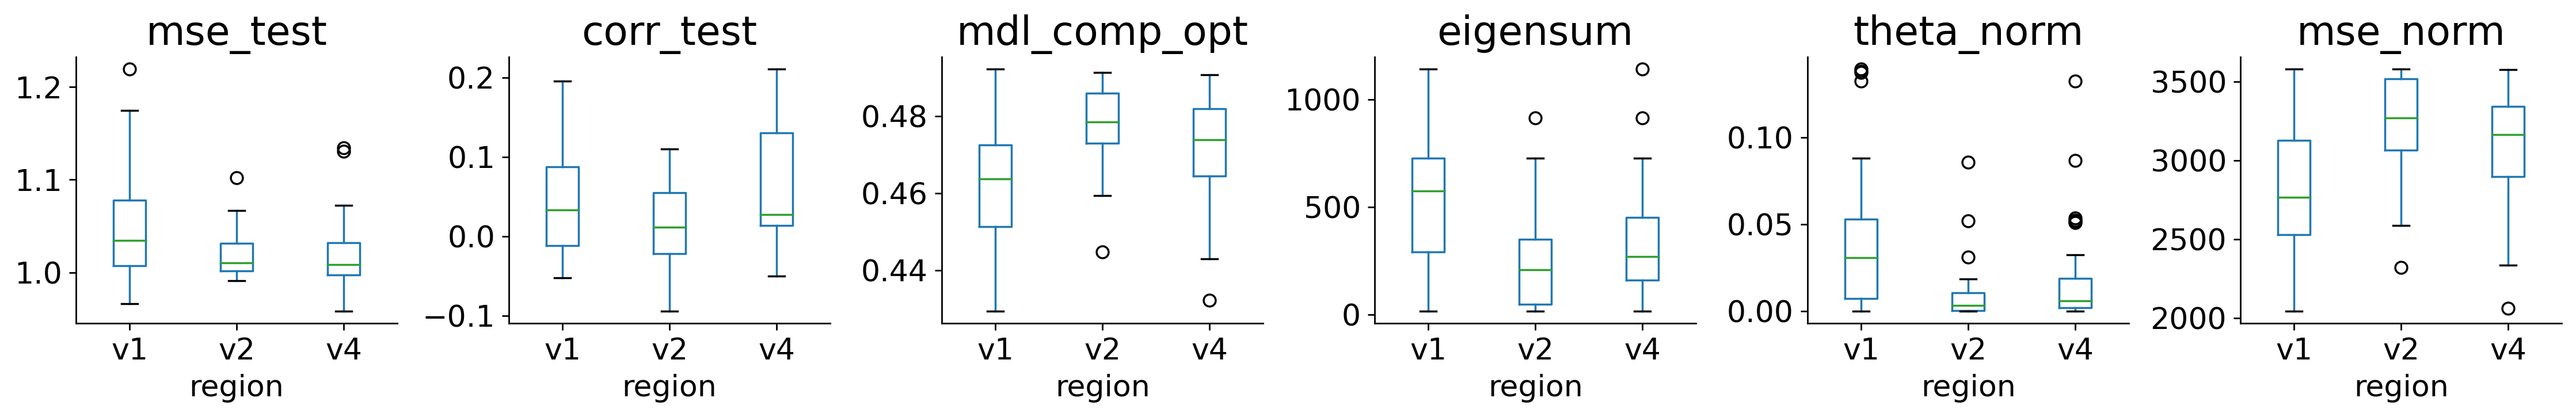

In [27]:
cols = ['mse_test', 'corr_test', 'mdl_comp_opt', 'eigensum', 'theta_norm', 'mse_norm'] #, 'complexity1', 'complexity2', 'mse_train']
f, axes = plt.subplots(1, len(cols), figsize=(3 * len(cols), 3), dpi=250)
axes = axes.flatten()
for i, col in enumerate(cols):
    # plt.subplot(R, C, 1)
    r.boxplot(by='region', column=col, ax=axes[i], grid=False)
plt.suptitle('')
plt.tight_layout()
plt.show()

# evaluate complexity curves

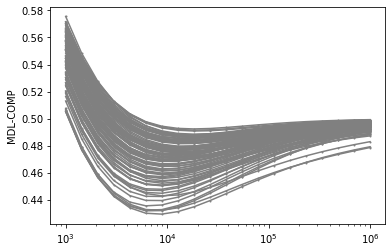

In [12]:
for i in range(r.shape[0]):
    plt.plot(reg_params, r.iloc[i]['mdl_comps'], 'o-', ms=1, color='gray')
    plt.ylabel('MDL-COMP')
plt.xscale('log')

In [ ]:
R, C = 1, 2
plt.figure(dpi=200)
for i in range(r.shape[0]): #min(5, r.shape[0])): #r.shape[0]):
    row = r.iloc[i]
    plt.subplot(R, C, 1)
    plt.plot(row['mdl_comps'], row['mse_tests'], 'o-', ms=1)
    plt.xlabel('MDL-COMP')
    plt.ylabel('MSE Test')
    
    plt.subplot(R, C, 2)
    plt.plot(row['cv_values'].mean(axis=0), row['mse_tests'], 'o-', ms=1)
    plt.xlabel('MSE CV')
    plt.ylabel('MSE Test')

plt.subplot(R, C, 1)    
plt.text(np.max(row['mdl_comps']) * 0.8, 1.1, 'Increasing\nregularization\nis lower\non the curve', )
plt.tight_layout()

# basic voxel viz

In [65]:
idxs = r.idx.values
vals = r.mdl_comp_opt
vol = np.zeros(73728) * np.nan
vol[idxs] = vals
vol = vol.reshape(18, 64, 64)
vol = vol.transpose()

In [66]:
print(vol.shape, np.nansum(vol), np.nansum(np.nansum(vol, axis=0), axis=0), np.nanmin(vol), np.nanmax(vol))

(64, 64, 18) 1206.7889855211408 [  0.         773.17322289 184.67265035  50.39903991  46.784434
 144.92879625   6.83084212   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ] 6.4444405630721 24.738911106879222


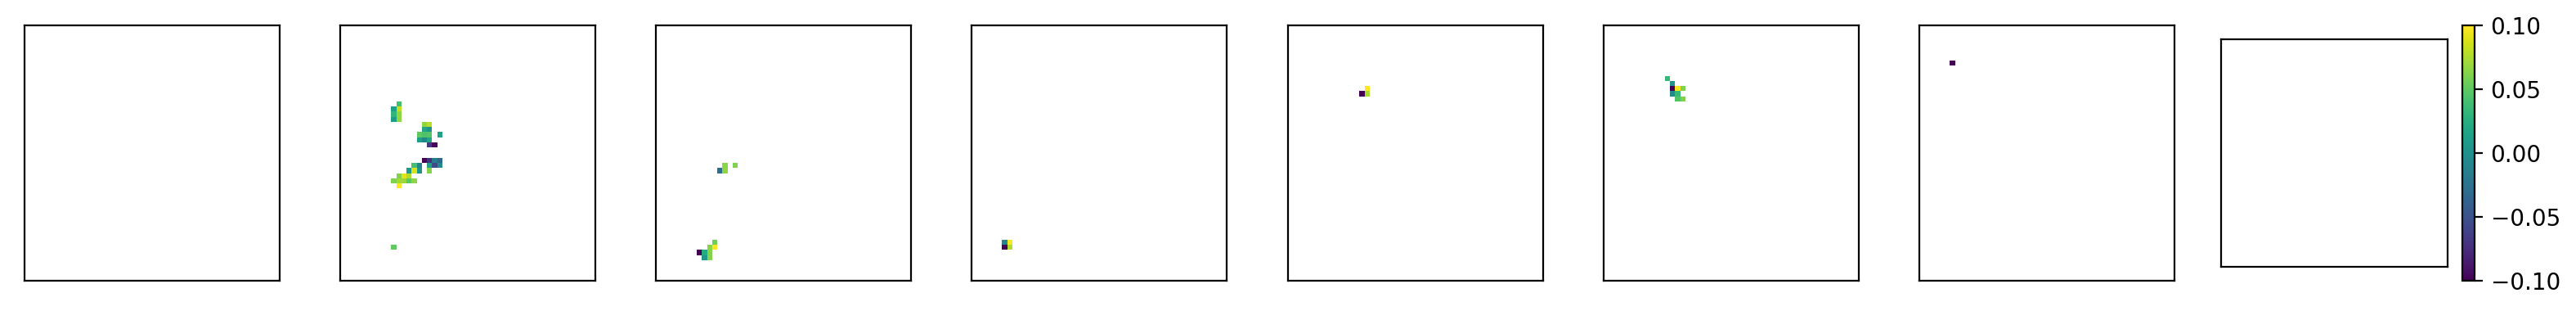

In [67]:
R, C = 1, 8
plt.figure(figsize=(C * 2, R * 2), dpi=200)
vmin = np.nanmin(vol)
vmax = np.nanmax(vol)
for i in range(8):
    plt.subplot(R, C, i + 1)
    NUM = 7
    plt.imshow(vol[NUM: -NUM, NUM: -NUM, i]) #, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
plt.colorbar()
plt.tight_layout()
plt.show()
# plt.imshow(vol[:, :, 15])

(64, 64, 18, 3)


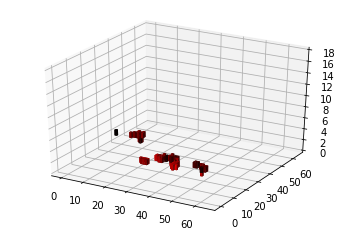

In [68]:
voxels = ~np.isnan(vol)
colors = vol
colors = (colors - np.nanmin(colors)) / (np.nanmax(colors) - np.nanmin(colors))
s = colors.shape
colors = colors.reshape((s[0], s[1], s[2], 1))
colors = colors.repeat(axis=-1, repeats=3)
colors[..., 1:] = 0
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors) #, edgecolor='k')

plt.show()

# pycortex

- install pycortex by cloning and running python setup.py install
- the config file is located at `cortex.options.usercfg`
    - edit this file to change the default_filestore to cortex installation filestore/db folder
    - also edit it to change the colormaps to cortex installation filestore/colormaps folder
- install fsl: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL
    - edit fsl_prefix in the config file based on what was installed
- need to make sure fsl can run properly: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslInstallation/ShellSetup

In [1]:
import nibabel as nib
import cortex
# from cortex import surfs

'''
img = nib.load(anat_file)
im_np = np.array(img.get_fdata())
im_np.shape

anat_file = oj(out_dir, 'anatomy/S1_anatomy.nii')
ret_file = 'S1_retinotopy.hdf'
ds = cortex.load(ret_file)
'''

"\nimg = nib.load(anat_file)\nim_np = np.array(img.get_fdata())\nim_np.shape\n\nanat_file = oj(out_dir, 'anatomy/S1_anatomy.nii')\nret_file = 'S1_retinotopy.hdf'\nds = cortex.load(ret_file)\n"

In [2]:
cortex.options.usercfg

'/Users/chandan/Library/Application Support/pycortex/options.cfg'

In [ ]:
cortex.align.automatic('S1', 'example-transform', '../data/anatomy/S1_anatomy.nii')

In [ ]:
m = cortex.quickshow((np.random.randn(31, 100, 100), "S1", "fullhead"))

# nilearn plotting

In [40]:
x = np.random.randn(64, 64, 18)

In [41]:
from nilearn import plotting, datasets

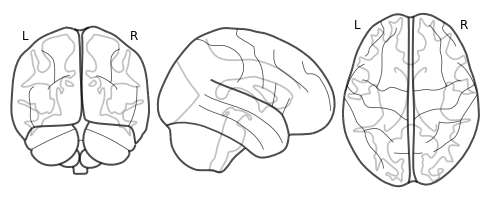

In [44]:
plotting.plot_glass_brain(None) #, annotate=False, black_bg=True)

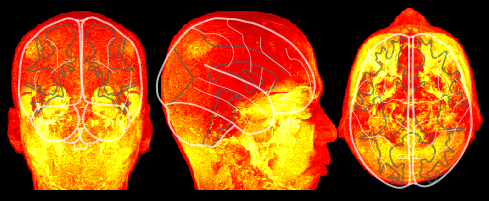

In [32]:
plotting.plot_glass_brain(anat_file, annotate=False, black_bg=True)

In [56]:
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]
# stat_img is just the name of the file that we downloded
stat_img


Dataset created in /accounts/projects/vision/nilearn_data/neurovault



'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'